# Lab 6: Automating Machine Learning Pipelines with Apache Airflow

## Objective
The objective of this lab is to help learners understand the concept of machine learning pipelines and how to automate them effectively. Participants will gain practical experience using Apache Airflow to create, schedule, and monitor a complete ML pipeline. This includes hands-on practice in building workflows for data preprocessing, model training, and evaluation, enabling learners to automate and streamline the entire machine learning process.

# Steps
- Step-1:  Intsllation of Apache Airflow
- Step-2 Develop ML Model Pipeline
- Step-3: Complete Airflow DAG Script
- Step-4: Run the ML Pipeline DAG


#### Explanation

1. **Directed Acyclic Graphs (DAGs) in Airflow**
   - A DAG in Airflow represents a collection of tasks organized in a directed acyclic manner, ensuring no task depends on itself directly or indirectly.
   - DAGs define the workflow of tasks and their dependencies, providing a clear execution order.

2. **Components of an ML Pipeline**
   - **Data Ingestion**: The process of collecting raw data from various sources like databases, APIs, or files for further processing.
   - **Data Preprocessing**: Cleaning, transforming, and preparing data to make it suitable for machine learning models. This step may include handling missing values, encoding categorical data, and feature scaling.
   - **Model Training**: Using the preprocessed data to train machine learning models to identify patterns and make predictions.
   - **Model Evaluation**: Assessing the performance of the trained model using metrics like accuracy, precision, recall, or F1-score to ensure it meets the desired objectives.
   - **Model Deployment (Optional)**: Deploying the trained model to a production environment for real-world usage, enabling predictions on new data.

## Step-1:  Intsllation of Apache Airflow

In [ ]:
# refer this link for local airflow setup -https://airflow.apache.org/docs/apache-airflow/stable/howto/docker-compose/index.html#fetching-docker-compose-yaml

## Step-2 Develop ML Model Pipeline

### Data Ingestion

In [ ]:
from sklearn.datasets import load_iris
import pandas as pd

data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df.to_csv('data/iris.csv', index=False)


### Data Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_test

array([[ 0.35451684, -0.58505976,  0.55777524,  0.02224751],
       [-0.13307079,  1.65083742, -1.16139502, -1.17911778],
       [ 2.30486738, -1.0322392 ,  1.8185001 ,  1.49058286],
       [ 0.23261993, -0.36147005,  0.44316389,  0.4227026 ],
       [ 1.2077952 , -0.58505976,  0.61508092,  0.28921757],
       [-0.49876152,  0.75647855, -1.27600637, -1.04563275],
       [-0.2549677 , -0.36147005, -0.07258719,  0.15573254],
       [ 1.32969211,  0.08570939,  0.78699794,  1.49058286],
       [ 0.47641375, -1.92659808,  0.44316389,  0.4227026 ],
       [-0.01117388, -0.80864948,  0.09932984,  0.02224751],
       [ 0.84210448,  0.30929911,  0.78699794,  1.09012776],
       [-1.23014297, -0.13788033, -1.33331205, -1.44608785],
       [-0.37686461,  0.98006827, -1.39061772, -1.31260282],
       [-1.10824606,  0.08570939, -1.27600637, -1.44608785],
       [-0.86445224,  1.65083742, -1.27600637, -1.17911778],
       [ 0.59831066,  0.53288883,  0.55777524,  0.55618763],
       [ 0.84210448, -0.

### Model Training

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

### Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")
with open('results/accuracy.txt', 'w') as f:
    f.write(f"Accuracy: {accuracy}")

Model Accuracy: 1.0


# Step-3: Complete Airflow DAG Script

In [ ]:
## use below script in airflow environment
"""

from airflow import DAG
from airflow.operators.python_operator import PythonOperator
from datetime import datetime
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import joblib
import os

# Ensure the necessary directories exist
os.makedirs('data', exist_ok=True)
os.makedirs('results', exist_ok=True)

# Step 1: Data Ingestion
def data_ingestion():
    data = load_iris()
    df = pd.DataFrame(data.data, columns=data.feature_names)
    df['target'] = data.target
    df.to_csv('data/iris.csv', index=False) # Ensure the dataset is saved as 'data/iris.csv'
    print("Data ingestion completed. Dataset loaded.")

# Step 2: Data Preprocessing
def data_preprocessing():
    print("Starting data preprocessing...")
    df = pd.read_csv('data/iris.csv')
    X = df.drop('target', axis=1)  # Features
    y = df['target']  # Target

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Save preprocessed data
    pd.DataFrame(X_train).to_csv('data/X_train.csv', index=False)
    pd.DataFrame(X_test).to_csv('data/X_test.csv', index=False)
    pd.DataFrame(y_train, columns=['target']).to_csv('data/y_train.csv', index=False)
    pd.DataFrame(y_test, columns=['target']).to_csv('data/y_test.csv', index=False)

    # Save the scaler
    joblib.dump(scaler, 'results/scaler.pkl')
    print("Data preprocessing completed. Preprocessed data and scaler saved.")

# Step 3: Model Training
def model_training():
    print("Starting model training...")
    X_train = pd.read_csv('data/X_train.csv')
    y_train = pd.read_csv('data/y_train.csv')

    # Convert y_train to a 1D array
    y_train = y_train.values.ravel()

    # Train the model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Save the trained model
    joblib.dump(model, 'results/model.pkl')
    print("Model training completed. Model saved to 'results/model.pkl'.")

# Step 4: Model Evaluation
def model_evaluation():
    print("Starting model evaluation...")
    X_test = pd.read_csv('data/X_test.csv')
    y_test = pd.read_csv('data/y_test.csv')

    # Convert y_test to a 1D array
    y_test = y_test.values.ravel()

    # Load the model
    model = joblib.load('results/model.pkl')

    # Make predictions
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model Accuracy: {accuracy}")

    # Save the accuracy result
    with open('results/accuracy.txt', 'w') as f:
        f.write(f"Accuracy: {accuracy}")
    print("Model evaluation completed. Accuracy saved to 'results/accuracy.txt'.")

# Step 5: Model Serving (Flask API)
def model_serving():
    print("Starting model serving...")
    # Load the trained model
    model = joblib.load('results/model.pkl')

    # Load the scaler
    scaler = joblib.load('results/scaler.pkl')

    # Create a Flask app
    from flask import Flask, request, jsonify
    app = Flask(__name__)

    @app.route('/predict', methods=['POST'])
    def predict():
        # Get input data from the request
        data = request.get_json()

        # Convert input data to a DataFrame with the correct feature names
        input_data = pd.DataFrame([data], columns=[
            "sepal length (cm)",
            "sepal width (cm)",
            "petal length (cm)",
            "petal width (cm)"
        ])

        # Scale the input data
        input_data_scaled = scaler.transform(input_data)

        # Make a prediction
        prediction = model.predict(input_data_scaled)
        return jsonify({'prediction': int(prediction[0])})

    # Run the Flask app
    print("Model serving started. API is running on http://0.0.0.0:5000/predict")
    app.run(host='0.0.0.0', port=5000)

# Define the DAG
default_args = {
    'owner': 'airflow',
    'start_date': datetime(2023, 10, 1),
    'retries': 1,
}

dag = DAG(
    'ml_pipeline_dag',
    default_args=default_args,
    description='End-to-End ML Pipeline with Airflow',
    schedule_interval='@daily',  # Run the DAG daily
    catchup=False,  # Disable catchup to avoid backfilling
)

# Define tasks
ingestion_task = PythonOperator(
    task_id='data_ingestion',
    python_callable=data_ingestion,
    dag=dag,
)

preprocessing_task = PythonOperator(
    task_id='data_preprocessing',
    python_callable=data_preprocessing,
    dag=dag,
)

training_task = PythonOperator(
    task_id='model_training',
    python_callable=model_training,
    dag=dag,
)

evaluation_task = PythonOperator(
    task_id='model_evaluation',
    python_callable=model_evaluation,
    dag=dag,
)

serving_task = PythonOperator(
    task_id='model_serving',
    python_callable=model_serving,
    dag=dag,
)

# Define task dependencies
ingestion_task >> preprocessing_task >> training_task >> evaluation_task >> serving_task

"""

# Step-4: Run the ML Pipeline DAG
- Save the script as ml_pipeline_dag.py in the dags folder of your Airflow installation.

- Install the required Python libraries (pandas, scikit-learn, joblib, flask) in your Airflow environment. with using requirements.txt file. refer link-https://airflow.apache.org/docs/apache-airflow/stable/howto/docker-compose/index.html#special-case-adding-dependencies-via-requirements-txt-file

- Restart airflow with docker-compose up -d --build

- Open the Airflow UI and verify that the ml_pipeline DAG appears in the list.

- Trigger the DAG manually and monitor its execution in the Airflow UI.

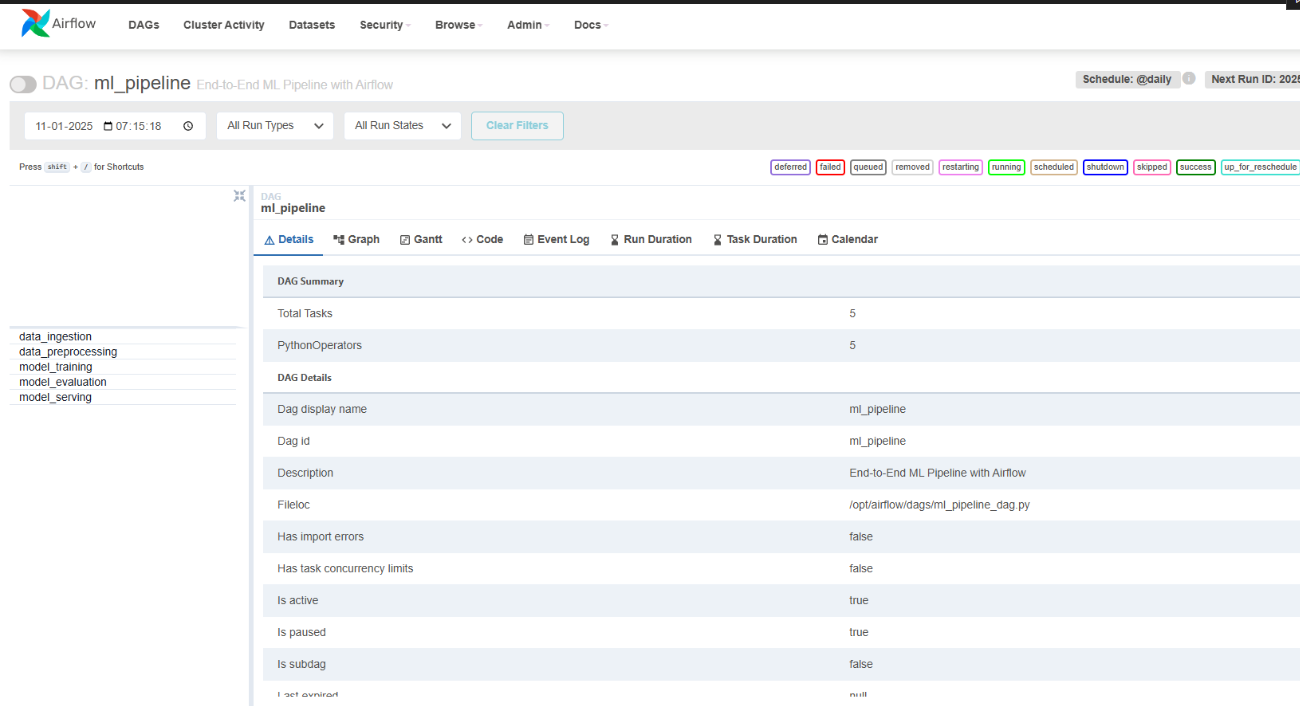

![image.png](attachment:image.png)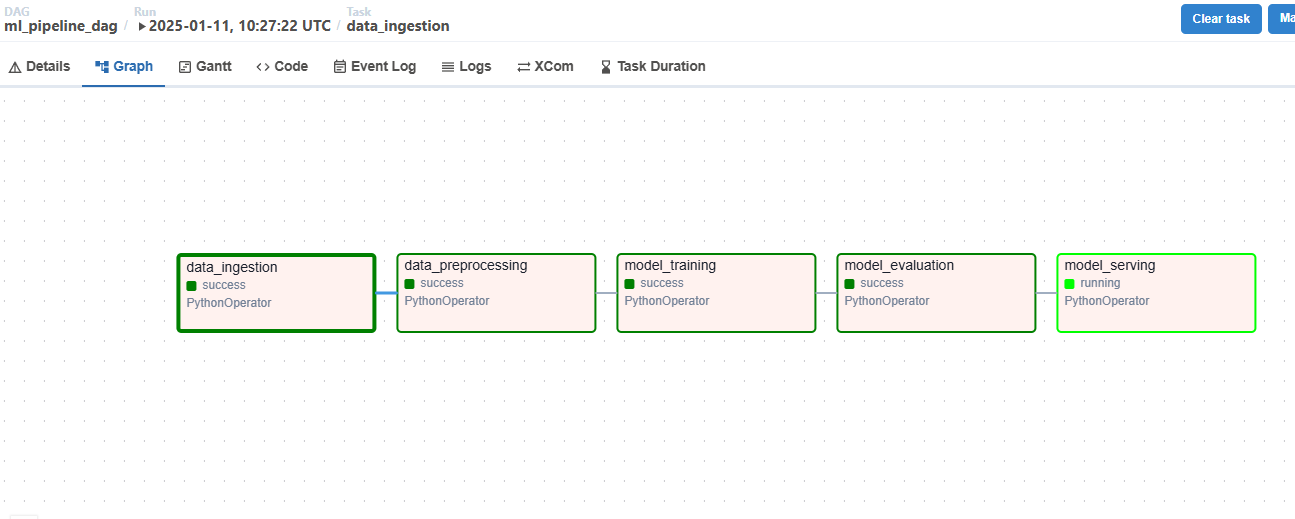

# Get prediction from the model

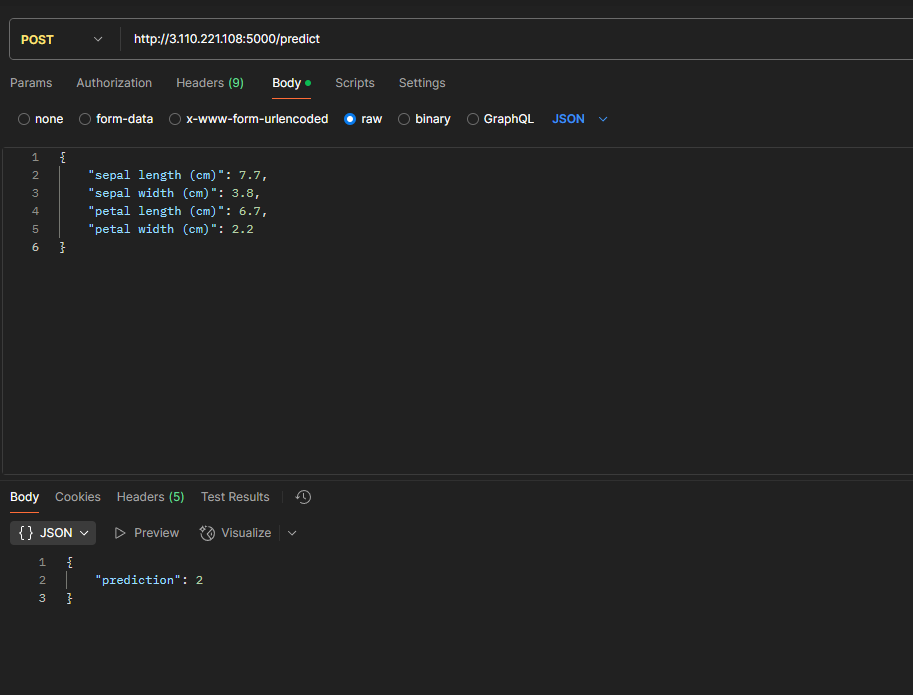